In [ ]:
 !git clone https://github.com/YuanGongND/cav-mae.git
# %cd cav-mae

# Install packages
!pip install timm==0.4.5 torch torchvision torchaudio numpy==1.23.5 scipy==1.10.1 librosa==0.10.0.post2 scikit-learn matplotlib

In [12]:
import urllib.request

url = "https://www.dropbox.com/s/l5t5geufdy3qvnv/audio_model.21.pth?dl=1"
urllib.request.urlretrieve(url, "audio_model.pth")


('audio_model.pth', <http.client.HTTPMessage at 0x7f76638bbc70>)

In [17]:
import os
print("Working directory:", os.getcwd())
print("Expected model path exists:", os.path.exists("../notebooks/cav-mae/audio_model.pth"))
print("Alt path exists:", os.path.exists("cav-mae/audio_model.pth"))


Working directory: /home/sude/e6691-2025spring-project-smab-af3410-sed2195-mt3846/notebooks
Expected model path exists: True
Alt path exists: True


In [ ]:
!ffmpeg -i ../movie.mp4 -r 1 ../feature_extraction/frames/frame_%04d.jpg


In [2]:
import sys
import os

import numpy as np
sys.path.append(os.path.abspath(".."))
from feature_extraction.cav_mae_extractor import initialize_model, get_audio_duration, extract_av_embeddings

#load audio + initialize model
y, sr, duration = get_audio_duration("../rest_audio.wav")
model = initialize_model()
#AV embeddings
embeddings = extract_av_embeddings(y, sr, duration, model)


A CAV-MAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  False
Number of Audio Patches: 512, Visual Patches: 196
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 196, 768])
Missing keys: [] 
Unexpected keys: []


 27%|██████████▋                            | 1003/3655 [00:50<02:13, 19.80it/s]

Processed 1000 / 3655 seconds


 55%|█████████████████████▎                 | 2002/3655 [01:41<01:24, 19.49it/s]

Processed 2000 / 3655 seconds


 82%|████████████████████████████████       | 3002/3655 [02:35<00:34, 18.90it/s]

Processed 3000 / 3655 seconds


100%|███████████████████████████████████████| 3655/3655 [03:09<00:00, 19.30it/s]

Final embeddings shape: (3655, 768)


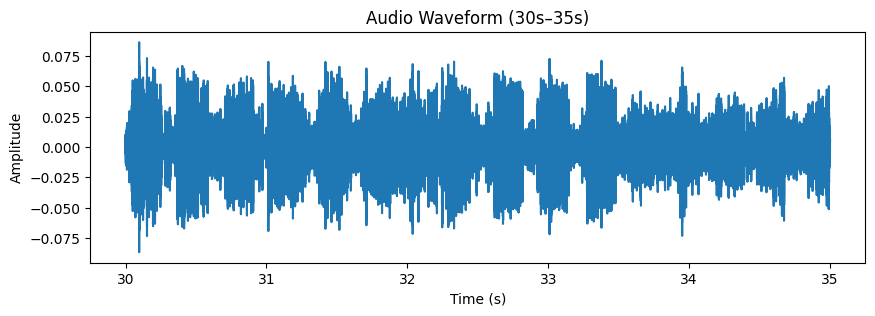

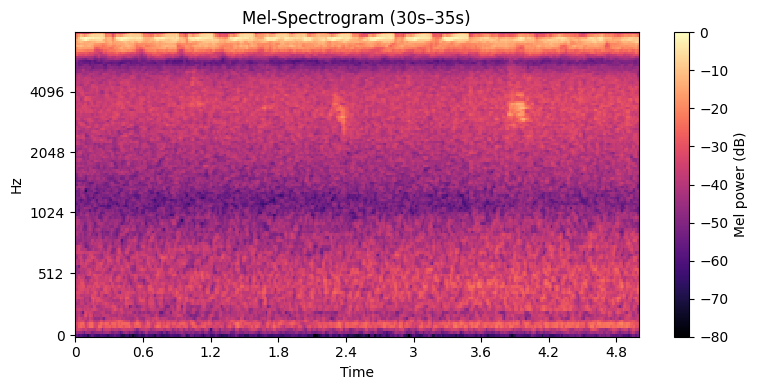

In [3]:
import matplotlib.pyplot as plt
import librosa.display
import os
from PIL import Image

#5 sec of audio to visualize
t_start, t_end = 30, 35
audio_snippet = y[int(t_start*sr): int(t_end*sr)]
time_axis = np.linspace(t_start, t_end, len(audio_snippet))

#raw waveform for this chunk 
plt.figure(figsize=(10, 3))
plt.plot(time_axis, audio_snippet)
plt.title(f"Audio Waveform ({t_start}s–{t_end}s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

#show mel-spectrogram for the same 5-second window
S = librosa.feature.melspectrogram(y=audio_snippet, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(8, 4))
librosa.display.specshow(S_db, sr=sr, hop_length=256, x_axis='time', y_axis='mel')
plt.colorbar(label='Mel power (dB)')
plt.title(f"Mel-Spectrogram ({t_start}s–{t_end}s)")
plt.tight_layout()
plt.show()

#earliy, middle, end samples
sample_times = [30, duration//3, duration]
for t in sample_times:
    frame_path = f"frames/frame_{t:04d}.jpg"
    if not os.path.exists(frame_path):
        continue
    img = Image.open(frame_path).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Frame at t={t}s")
    plt.axis('off')
    plt.show()


In [4]:
# # Extract audio to WAV and video frames (1 frame per second)]
# !mkdir -p frames
# !ffmpeg -y -i movie.mp4 -q:a 0 -map a movie.wav   # extract audio track
# !ffmpeg -y -i movie.mp4 -r 1 frames/frame_%04d.jpg   # extract 1 FPS frames

In [4]:
print("Shape of y:", y.shape)
print("Sample rate (sr):", sr)
print("Min:", np.min(y), "Max:", np.max(y), "Mean:", np.mean(y), "Std:", np.std(y))
print("First 10 values:", y[:10])


Shape of y: (58480478,)
Sample rate (sr): 16000
Min: -0.46520996 Max: 0.47854614 Mean: -1.6188698e-05 Std: 0.019901969
First 10 values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


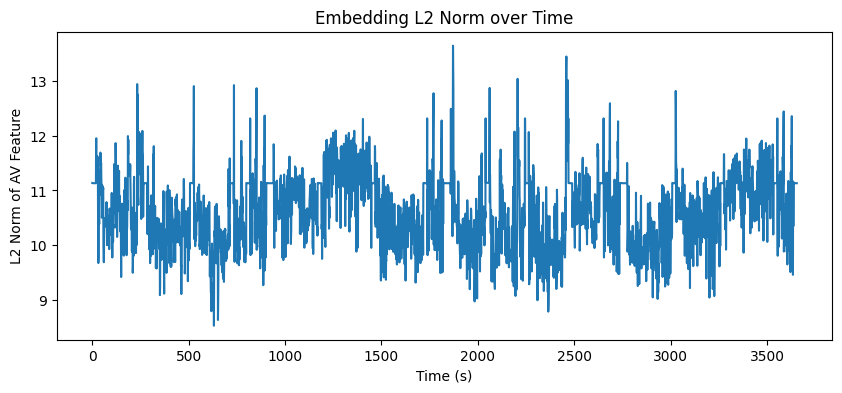

Explained variance by first 2 PCA components: [0.41656545 0.06712701]


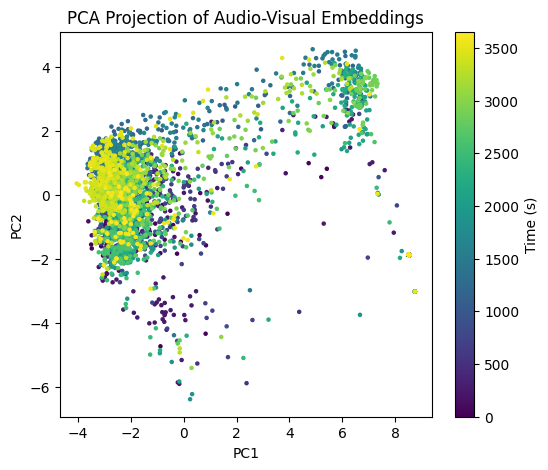

In [5]:
#L2 norm of each embedding vector
embeddings_norm = np.linalg.norm(embeddings, axis=1)
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(embeddings_norm)), embeddings_norm)
plt.title("Embedding L2 Norm over Time")
plt.xlabel("Time (s)")
plt.ylabel("L2 Norm of AV Feature")
plt.show()

#pca to 2 dimensions for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)
print("Explained variance by first 2 PCA components:", pca.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
sc = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=np.arange(len(embeddings)), cmap='viridis', s=5)
plt.colorbar(sc, label="Time (s)")
plt.title("PCA Projection of Audio-Visual Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [7]:
import scipy.io
scipy.io.savemat("audiovisual_features.mat", {"audiovisual_embeddings": embeddings})
print("Saved embeddings to 'audiovisual_features.mat'")


 27%|███████████████████▋                                                    | 1002/3655 [00:51<02:18, 19.19it/s]

Processed 1000 / 3655 seconds


 55%|███████████████████████████████████████▍                                | 2003/3655 [01:45<01:29, 18.40it/s]

Processed 2000 / 3655 seconds


 82%|███████████████████████████████████████████████████████████▏            | 3003/3655 [02:39<00:35, 18.19it/s]

Processed 3000 / 3655 seconds


100%|████████████████████████████████████████████████████████████████████████| 3655/3655 [03:15<00:00, 18.73it/s]

Final embeddings shape: (3655, 768)
